# IEEE-CIS Fraud Detection

## Detect Fraudulent Transactions

Imagine standing at the check-out counter at the grocery store with a long line behind you and the cashier not-so-quietly announces that your card has been declined. In this moment, you probably aren’t thinking about the data science that determined your fate.

Embarrassed, and certain you have the funds to cover everything needed for an epic nacho party for 50 of your closest friends, you try your card again. Same result. As you step aside and allow the cashier to tend to the next customer, you receive a text message from your bank. “Press 1 if you really tried to spend $500 on cheddar cheese.”

While perhaps cumbersome (and often embarrassing) in the moment, this fraud prevention system is actually saving consumers millions of dollars per year. Researchers from the IEEE Computational Intelligence Society (IEEE-CIS) want to improve this figure, while also improving the customer experience. With higher accuracy fraud detection, you can get on with your chips without the hassle.



---

> **Note** : The notebook is only used for analysis purpose.

To solve the above stated problem, the data is acquired from [Kaggle.com](https://www.kaggle.com/competitions/ieee-fraud-detection/overview).

**Objective of the machine learning model** :  
The aim is to find or devise a model that has a good emasure of separability between the classes. The model performance will be judged on the basis of [ROC-AUC](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc) metric.

In [1]:
# Importing libraries
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the data
train_transaction_df = pd.read_csv("../data/train_transaction.csv")
train_identity_df = pd.read_csv("../data/train_identity.csv")

# Number of rows and columns
print(f"Train transaction: {train_transaction_df.shape}")
print(f"Train identity: {train_identity_df.shape}")

Train transaction: (590540, 394)
Train identity: (144233, 41)


All together there are 433 predictive features, and 1 is the target variable: `isFraud`

In [3]:
# Preview transaction dataset
train_transaction_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Preview identity dataset
train_identity_df.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
# Combine the dataset, join by the TransactionID.
# Remember: Not all transactions have corresponding identity information.
dataset = pd.merge(
    train_transaction_df,
    train_identity_df,
    how="left",
    on="TransactionID"
)

# Confirm that the join was succesful
print(f"Combined data -> {dataset.shape}")

Combined data -> (590540, 434)


## Exploring the data
**Analysing the following:**
1. target feature
1. Features types (categorical and numerical)
1. Missing data
    - Numerical variables
    - Categorical variables

### 1. target feature

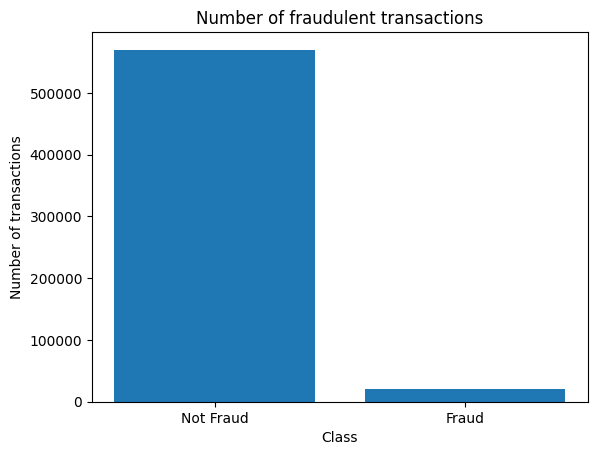

In [6]:
# Target feature bar plot
x = ["Not Fraud", "Fraud"]

plt.bar(
    x=x,
    height=dataset["isFraud"].value_counts()
)

plt.title("Number of fraudulent transactions")
plt.xlabel("Class")
plt.ylabel("Number of transactions")
plt.show()

As seen from above figure, there is a severe imbalance of the classes. Some sampling techniques can be applied to balance the classes - [Oversampling and Undersampling](https://towardsdatascience.com/oversampling-and-undersampling-5e2bbaf56dcf).

### 2. Feature types (categorical and numerical)
Accoring to data dictionary:
1. Categorical Features - Transaction
    - `ProductCD`
    - `card1 - card6`
    - `addr1, addr2`
    - `P_emaildomain`
    - `R_emaildomain`
    - `M1 - M9`
1. Categorical Features - Identity
    - `DeviceType`
    - `DeviceInfo`
    - `id_12 - id_38`

In [7]:
# Identifying the categorical features by
# capturing those of type *object*
cat_cols = list(dataset.select_dtypes(include=['object']).columns)
print(f"Number of categorical columns: {len(cat_cols)}")
print(f"Categorical columns:\n{cat_cols}")

Number of categorical columns: 31
Categorical columns:
['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


Some features may have different data types, which is why they are not displayed here.

In [8]:
# checking the datatype of features that
# are documented as categorical
dataset[["card1", "card2", "card3", "card5",
         "addr1", "addr2", "id_13", "id_14",
         "id_17", "id_18", "id_19", "id_20",
         "id_21", "id_22", "id_24", "id_25",
         "id_26", "id_32"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 18 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   card1   590540 non-null  int64  
 1   card2   581607 non-null  float64
 2   card3   588975 non-null  float64
 3   card5   586281 non-null  float64
 4   addr1   524834 non-null  float64
 5   addr2   524834 non-null  float64
 6   id_13   127320 non-null  float64
 7   id_14   80044 non-null   float64
 8   id_17   139369 non-null  float64
 9   id_18   45113 non-null   float64
 10  id_19   139318 non-null  float64
 11  id_20   139261 non-null  float64
 12  id_21   5159 non-null    float64
 13  id_22   5169 non-null    float64
 14  id_24   4747 non-null    float64
 15  id_25   5132 non-null    float64
 16  id_26   5163 non-null    float64
 17  id_32   77586 non-null   float64
dtypes: float64(17), int64(1)
memory usage: 85.6 MB


In [9]:
# Adding these features to categorical columns
cat_cols += ["card1", "card2", "card3", "card5",
             "addr1", "addr2", "id_13", "id_14",
             "id_17", "id_18", "id_19", "id_20",
             "id_21", "id_22", "id_24", "id_25",
             "id_26", "id_32"]

# Casting all these features to categorical
dataset[cat_cols] = dataset[cat_cols].astype("O")

The data disctionary states that `TransactionDT` feature is a timedelta from a given reference datatime (not an actual timestamp).

In [10]:
# Checking datatype
dataset[["TransactionDT"]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   TransactionDT  590540 non-null  int64
dtypes: int64(1)
memory usage: 9.0 MB


In [11]:
# Collecting all numerical features
# that aren't the target label or in cat_cols
num_cols = [x for x in dataset.select_dtypes(include=["number"]).columns
            if x not in cat_cols
            if x not in ["isFraud"]]
print(f"Number of numerical columns: {len(num_cols)}")

Number of numerical columns: 384


### 3. Missing values
Many machine learning models require to deal with missing values beofre passing the training data to it. Understanding the features with missing values could provide us some insight into how to deal with that particular feature, either by deletion or imputation.

In [12]:
# List of columns that have null values
features_with_na = [col for col in dataset.columns if dataset[col].isna().sum() > 0]

# Precentage of missing data
missing_values_df = pd.DataFrame(dataset[features_with_na].isnull().mean().sort_values(ascending=False), columns=["percentage"])
missing_values_df.head(10)

,percentage
id_24,0.991962
id_25,0.991310
id_07,0.991271
id_08,0.991271
id_21,0.991264
id_26,0.991257
id_27,0.991247
id_23,0.991247
id_22,0.991247
dist2,0.936284


How many of missing features are above some threshold.

In [13]:
# How many features are missing more than some threshold
print(
    f"25% : {len(missing_values_df[missing_values_df['percentage'] > 0.25])}\n\
50% :  {len(missing_values_df[missing_values_df['percentage'] > 0.50])}\n\
75% :  {len(missing_values_df[missing_values_df['percentage'] > 0.75])}\n\
80% :  {len(missing_values_df[missing_values_df['percentage'] > 0.80])}\n\
90% :  {len(missing_values_df[missing_values_df['percentage'] > 0.90])}\n"
)

25% : 252
50% :  214
75% :  208
80% :  74
90% :  12



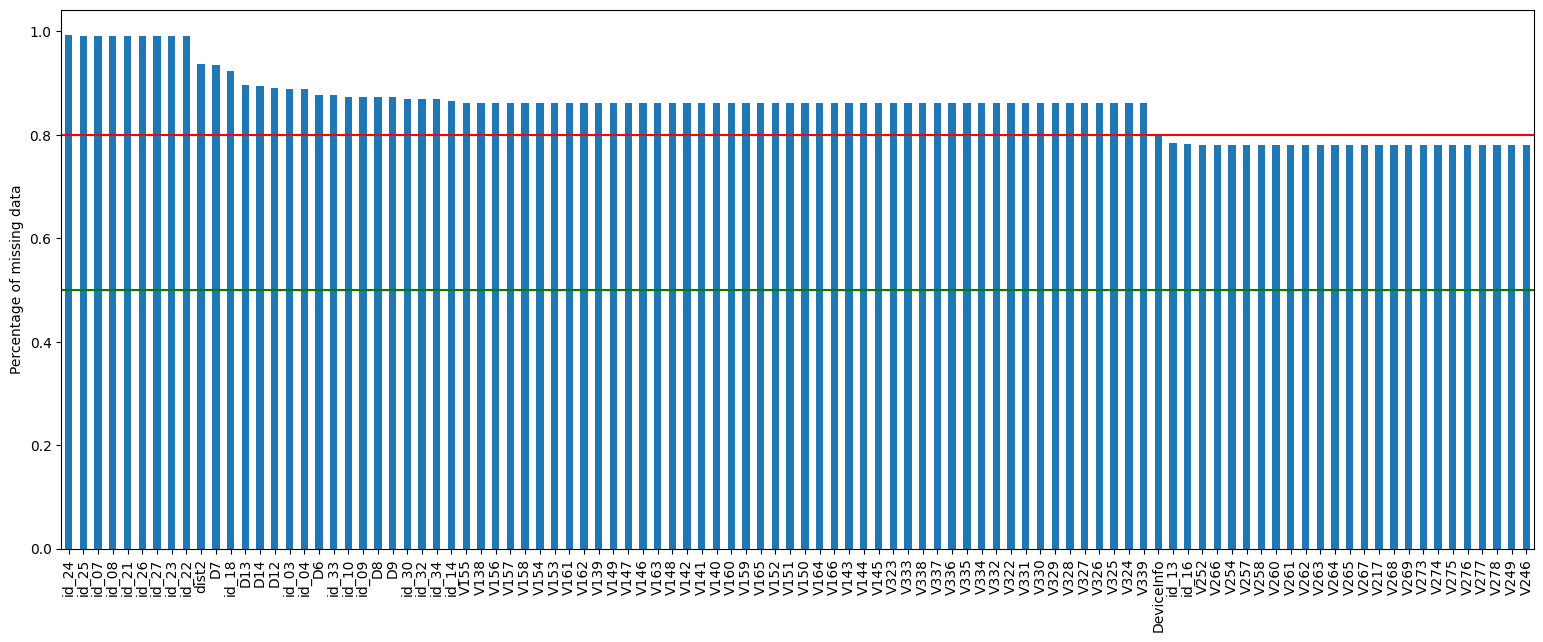

In [14]:
# Plotting for better understanding
missing_values_df[:100].plot.bar(figsize=(19, 7), legend=None)
plt.ylabel("Percentage of missing data")
plt.axhline(y=0.80, color='r', linestyle='-')
plt.axhline(y=0.50, color='g', linestyle='-')
plt.xticks(rotation=90)
plt.show()

A large portion of features (74) are missing more than 80% of values. Since the instances are annonymized for protection of the customers, we can **consider** dropping features with high number of missing values as **there may be no clear way to identify how to engineer these features.** To begin with, I will start by separating the features into categorical and numerical.

In [15]:
cat_na = [col for col in cat_cols if col in features_with_na]
num_na = [col for col in num_cols if col in features_with_na]

print(f"Number of categorical vairables with na: ", len(cat_na))
print(f"Number of numerical vairables with na: ", len(num_na))

Number of categorical vairables with na:  47
Number of numerical vairables with na:  367


In [16]:
# missing value percentages of categorical features at random thresholds
print(
    f"25%: {sum(missing_values_df.loc[cat_na, 'percentage'] > 0.25)}\n\
50%: {sum(missing_values_df.loc[cat_na, 'percentage'] > 0.50)}\n\
75%: {sum(missing_values_df.loc[cat_na, 'percentage'] > 0.75)}\n\
80%: {sum(missing_values_df.loc[cat_na, 'percentage'] > 0.80)}\n\
90%: {sum(missing_values_df.loc[cat_na, 'percentage'] > 0.90)}"
)

25%: 39
50%: 34
75%: 30
80%: 13
90%: 8


In [17]:
# missing value percentages of numerical features at random thresholds
print(
    f"25%: {sum(missing_values_df.loc[num_na, 'percentage'] > 0.25)}\n\
50%: {sum(missing_values_df.loc[num_na, 'percentage'] > 0.50)}\n\
75%: {sum(missing_values_df.loc[num_na, 'percentage'] > 0.75)}\n\
80%: {sum(missing_values_df.loc[num_na, 'percentage'] > 0.80)}\n\
90%: {sum(missing_values_df.loc[num_na, 'percentage'] > 0.90)}"
)


25%: 213
50%: 180
75%: 178
80%: 61
90%: 4


There is definitely more analysis that can be performed to better grasp the nature of the data. For instance, to understand the relationship of the features with the target, we can look into the distributions of the features itself.